In [37]:
# import other files
%run validation.ipynb

# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import shap
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping

# for exporting models
import joblib

In [38]:
random.seed(123)
np.random.seed(123)
tf.random.set_seed(123)

In [44]:
# import data from "nba_data_collection" stage
all_nba_df = pd.read_csv('./data/all_stats_2000_23.csv')

# clean up the unuseful columns
all_nba_df = all_nba_df.drop(['NICKNAME', 'TEAM_ID', 'NBA_FANTASY_PTS', 'WNBA_FANTASY_PTS', 'NBA_FANTASY_PTS_RANK', 'WNBA_FANTASY_PTS_RANK', 'FGA_PG', 'FGM_PG'], axis=1)

# we are trying to predict the NBA 2022-23 MVP, so isolate this season out
nba_2023 = pd.read_csv('./data/all_stats_2000_23.csv')
nba_2023 = nba_2023[(nba_2023['season_id']== '2022-23')].reset_index(drop=True)
# import team stats to get Game Played stats
team_stats_2022_23_df = pd.read_csv('./data/team_stats_2022_23.csv')
team_stats_2022_23_df = team_stats_2022_23_df[['TEAM_ID', 'GP']]
team_stats_2022_23_df = team_stats_2022_23_df.rename({'GP': 'team_GP'}, axis=1)

nba_2023 = pd.merge(nba_2023, team_stats_2022_23_df, left_on = ['TEAM_ID'], right_on = ['TEAM_ID'], how = 'left')
nba_2023['GP_PCT'] = nba_2023['GP']/nba_2023['team_GP']
nba_2023 = nba_2023.drop(['NICKNAME', 'TEAM_ID', 'GP','NBA_FANTASY_PTS', 'WNBA_FANTASY_PTS', 'NBA_FANTASY_PTS_RANK', 'WNBA_FANTASY_PTS_RANK', 'team_GP', 'FGA_PG', 'FGM_PG'], axis=1)

In [45]:
past_mvps = pd.read_csv('./data/past_mvps_2000_22.csv')
past_mvps = past_mvps[['Player', 'season_id', 'Share']]

# left join all nba stats and mvp results
nba_2000_22 = all_nba_df[(all_nba_df['season_id']!= '2022-23')].reset_index(drop=True)
nba_2000_22 = pd.merge(nba_2000_22, past_mvps, left_on = ['PLAYER_NAME', 'season_id'], right_on = ['Player', 'season_id'], how = 'left')
nba_2000_22['GP_PCT'] = nba_2000_22['GP']/82
nba_2000_22 = nba_2000_22.drop(['Player', 'GP'], axis=1)
nba_2000_22['Share'] = nba_2000_22['Share'].fillna(0.000)

In [46]:
# since there are approx. 450 players in the NBA per season, but not all are qualified for MVP selection. We use past MVP's lowest stats to filter players out
# the stats we are using are the ones that show the impact of players on their teams
# Filter:
# winning percentage: lowest winning percentage on MVP's team in the past is 45.3%
# minutes per game: lowest minutes per game for a MVP is 30.4 min
# GP: lowest game played for an MVP per season is 49 per game
# +/-: lowest +/- for an MVP is 3.1
# offensive rating: lowest offensive rating is 104.7
# defensive rating: highest defensive rating is 110.6
# since we might mis-filter past MVPs out so if they had MVP shares, we still keep the players
# &(nba_2000_22['OFF_RATING'] >= 104.7)&(nba_2000_22['DEF_RATING'] <= 110.6)
filtered_nba_2000_22 = nba_2000_22[((nba_2000_22['W_PCT'] >= 0.453)&
                                    (nba_2000_22['MIN'] >= 30.4)&
                                    (nba_2000_22['GP_PCT'] >= 0.5976)&
                                    (nba_2000_22['PLUS_MINUS'] >= 3.1)&
                                    (nba_2000_22['OFF_RATING'] >= 104.7)&
                                    (nba_2000_22['DEF_RATING'] <= 110.6))|(nba_2000_22['Share']>0)].reset_index(drop=True)
nba_2023 = nba_2023[((nba_2023['W_PCT'] >= 0.453)&
                     (nba_2023['MIN'] >= 30.4)&
                     (nba_2023['GP_PCT'] >= 0.5976)&
                     (nba_2023['PLUS_MINUS'] >= 3.1))].reset_index(drop=True)
nba_2023_model = nba_2023.drop(['PLAYER_ID', 'PLAYER_NAME', 'TEAM_ABBREVIATION', 'season_id'], axis = 1)

In [47]:
# split training and testing data set 
# training: 2000-2018, testing: 2019-2022, predict: 2023
# training
nba_2000_18 = filtered_nba_2000_22.loc[(filtered_nba_2000_22['season_id'] != '2019-20') 
                         & (filtered_nba_2000_22['season_id'] != '2020-21')
                         & (filtered_nba_2000_22['season_id'] != '2021-22')]

share_2000_18 = nba_2000_18[['Share']].values.ravel()
nba_2000_18_model = nba_2000_18.drop(['Share', 'PLAYER_ID', 'PLAYER_NAME', 'TEAM_ABBREVIATION', 'season_id'], axis = 1)

# testing
nba_2019_22 = filtered_nba_2000_22.loc[(filtered_nba_2000_22['season_id'] == '2019-20') 
                         | (filtered_nba_2000_22['season_id'] == '2020-21')
                         | (filtered_nba_2000_22['season_id'] == '2021-22')]
share_2019_22 = nba_2019_22[['Share']].values.ravel()
nba_2019_22_model = nba_2019_22.drop(['Share', 'PLAYER_ID', 'PLAYER_NAME', 'TEAM_ABBREVIATION', 'season_id'], axis = 1)

In [48]:
# Assuming that X and y are already defined and X is a pandas DataFrame
# StandardScaler
scaler = StandardScaler()
scaler.fit(nba_2000_18_model)
nba_2000_18_scaled = scaler.transform(nba_2000_18_model)
nba_2019_22_scaled = scaler.transform(nba_2019_22_model)
nba_2023_scaled = scaler.transform(nba_2023_model)

# SelectKBest
k = 20 # number of top features to select
selector = SelectKBest(f_regression, k=k)
selector.fit(nba_2000_18_scaled, share_2000_18)
nba_2000_18_new = selector.transform(nba_2000_18_scaled)
nba_2019_22_new = selector.transform(nba_2019_22_scaled)
nba_2023_new = selector.transform(nba_2023_scaled)

# Get the p-values and F-scores of the selected features
p_values = selector.pvalues_
f_scores = selector.scores_
selected_features = nba_2000_18_model.columns[selector.get_support()]

# Print the selected feature names, F-scores and p-values
# for feature, f_score, p_value in zip(selected_features, f_scores, p_values):
#    print(f"Feature: {feature}, F-score: {f_score:.2f}, p-value: {p_value:.2g}")

In [49]:
selected_features

Index(['FGM', 'FGA', 'FTM', 'FTA', 'TOV', 'PTS', 'DD2', 'FGM_RANK', 'FGA_RANK',
       'TOV_RANK', 'PTS_RANK', 'AST_PCT', 'USG_PCT', 'E_USG_PCT', 'PIE',
       'USG_PCT_RANK', 'E_USG_PCT_RANK', 'PIE_RANK', 'FGM_PG_RANK',
       'FGA_PG_RANK'],
      dtype='object')

In [50]:
# create an empty dictionary to store the prediction results
test_values = {}
trained_models = {}

In [51]:
# Support Vector Regression 
param_grid = {'C': [0.001,0.01,0.1,0.5,1,2,5,10],
             'kernel': ['linear','rbf','poly'],
             'gamma': ['scale','auto'],
             'degree': [2,3,4],
             'epsilon': [0.1,0.5,1]}
model_svr = SVR()
kf = KFold(n_splits=10, shuffle=True, random_state=1)
grid = GridSearchCV(model_svr, param_grid, cv = kf)
grid.fit(nba_2000_18_new, share_2000_18)

# train SVR
model_svr.fit(nba_2000_18_new, share_2000_18)

SVR()

In [52]:
# save the model
joblib.dump(model_svr, './model/model_svr.joblib')

['./model/model_svr.joblib']

In [53]:
# get test set values
model_svr = joblib.load('./model/model_svr.joblib')
y_pred_svr = model_svr.predict(nba_2019_22_new)
trained_models['SVR'] = model_svr

y_pred_svr = np.clip(y_pred_svr, 0, 1)
test_values['SVR'] = y_pred_svr

# test result
svr_metrics = pd.DataFrame()
svr_metrics = testing_metrics(share_2019_22, y_pred_svr, svr_metrics, 'SVR', '2019_22')
svr_metrics

,Season,Model,RMSE,R_Square
0,2019_22,SVR,0.14,0.634


In [54]:
# Gradient Boosting
param_grid = {'n_estimators': [10,20,30,40,50],
                             'learning_rate': [0.01,0.05,0.1,0.2,0.5],
                             'max_depth': [3,4,5]}
gb_model = GradientBoostingRegressor()
kf = KFold(n_splits=10, shuffle=True, random_state=1)
grid = GridSearchCV(gb_model, param_grid, cv = kf)
grid.fit(nba_2000_18_new, share_2000_18)
model_gb = GradientBoostingRegressor(**grid.best_params_)

# train Gradient Boosting
model_gb.fit(nba_2000_18_new, share_2000_18)

GradientBoostingRegressor(learning_rate=0.05, n_estimators=40)

In [55]:
# save the model
joblib.dump(model_gb, './model/model_gb.joblib')

['./model/model_gb.joblib']

In [56]:
# get test set values
model_gb = joblib.load('./model/model_gb.joblib')
trained_models['Gradient Boosting'] = model_gb

y_pred_gb = model_gb.predict(nba_2019_22_new)
test_values['Gradient Boosting'] = y_pred_gb

# test result
gb_metrics = pd.DataFrame()
gb_metrics = testing_metrics(share_2019_22, y_pred_gb, gb_metrics, 'Gradient Boosting', '2019_22')
gb_metrics

,Season,Model,RMSE,R_Square
0,2019_22,Gradient Boosting,0.109,0.778


In [57]:
# Random Forest
param_grid = {'n_estimators': [100, 150, 200, 250],
                             'max_features': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20],
                             'bootstrap': [True,False],
                             'oob_score': [True,False]}
rfc = RandomForestRegressor()
kf = KFold(n_splits=10, shuffle=True, random_state=1)
grid = GridSearchCV(rfc, param_grid, cv = kf)
grid.fit(nba_2000_18_new, share_2000_18)
model_rf = RandomForestRegressor(**grid.best_params_)
model_rf.fit(nba_2000_18_new, share_2000_18)



400 fits failed out of a total of 1600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
400 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/frankhung/opt/anaconda3/envs/nba/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/frankhung/opt/anaconda3/envs/nba/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 434, in fit
    raise ValueError("Out of bag estimation only available if bootstrap=True")
ValueError: Out of bag estimation only available if bootstrap=True

One or more of the test scores are non-finite: [0.3528004  0.34304945 0.3535552  0.35268493 0.36523425 0.36301869
 0

RandomForestRegressor(max_features=18, n_estimators=200)

In [58]:
# save the RF model
joblib.dump(model_rf, './model/model_rf.joblib')

['./model/model_rf.joblib']

In [59]:
# get test set values
# load trained data
model_rf = joblib.load('./model/model_rf.joblib')
trained_models['Random Forest'] = model_rf

y_pred_rf = model_rf.predict(nba_2019_22_new)
test_values['Random Forest'] = y_pred_rf

# test result
rf_metrics = pd.DataFrame()
rf_metrics = testing_metrics(share_2019_22, y_pred_rf, rf_metrics, 'Random Forest', '2019_22')
rf_metrics

,Season,Model,RMSE,R_Square
0,2019_22,Random Forest,0.123,0.72


In [76]:
# NN
# Define the neural network architecture
df_shape = nba_2000_18_new.shape[1]

# layers of NN
np.random.seed(123)
tf.random.set_seed(123)
model_nn = keras.models.Sequential([keras.layers.Dense(16, activation='relu', input_shape=(df_shape,), kernel_regularizer=regularizers.l2(0.01))])
model_nn.add(layers.Dense(1, activation='relu'))

# Compile the model
model_nn.compile(optimizer='adam', loss='MSLE')

# Train the model
early_stopping = EarlyStopping(monitor='loss', patience=3)
model_nn.fit(nba_2000_18_new, share_2000_18, epochs=200, batch_size=10, callbacks=[early_stopping])

Epoch 1/200
57/57 [==============================] - 0s 673us/step - loss: 0.2447
Epoch 2/200
57/57 [==============================] - 0s 572us/step - loss: 0.1826
Epoch 3/200
57/57 [==============================] - 0s 595us/step - loss: 0.1506
Epoch 4/200
57/57 [==============================] - 0s 609us/step - loss: 0.1246
Epoch 5/200
57/57 [==============================] - 0s 583us/step - loss: 0.1035
Epoch 6/200
57/57 [==============================] - 0s 546us/step - loss: 0.0866
Epoch 7/200
57/57 [==============================] - 0s 567us/step - loss: 0.0734
Epoch 8/200
57/57 [==============================] - 0s 564us/step - loss: 0.0627
Epoch 9/200
57/57 [==============================] - 0s 600us/step - loss: 0.0533
Epoch 10/200
57/57 [==============================] - 0s 596us/step - loss: 0.0461
Epoch 11/200
57/57 [==============================] - 0s 626us/step - loss: 0.0400
Epoch 12/200
57/57 [==============================] - 0s 573us/step - loss: 0.0354
Epoch 13/200


In [77]:
# save the model
joblib.dump(model_nn, './model/model_nn.joblib')

INFO:tensorflow:Assets written to: ram://0f3bdc24-eb45-4fd7-b522-68d7e405f6d6/assets


['./model/model_nn.joblib']

In [78]:
# get test set values
# load trained data
model_nn = joblib.load('./model/model_nn.joblib')
trained_models['Neural Network'] = model_nn

# get testing result metrics
y_pred_nn = model_nn.predict(nba_2019_22_new)
y_pred_nn = y_pred_nn.reshape((nba_2019_22_new.shape[0],))
test_values['Neural Network'] = y_pred_nn

# test result
nn_metrics = pd.DataFrame()
nn_metrics = testing_metrics(share_2019_22, y_pred_nn, nn_metrics, 'Neural Network', '2019_22')
nn_metrics

3/3 [==============================] - 0s 870us/step


,Season,Model,RMSE,R_Square
0,2019_22,Neural Network,0.127,0.698


In [79]:
metrics = pd.DataFrame()
for key, value in test_values.items():
    metrics = testing_metrics(share_2019_22, value, metrics, key, '2019_22')
metrics

,Season,Model,RMSE,R_Square
0,2019_22,SVR,0.140,0.634
1,2019_22,Gradient Boosting,0.109,0.778
2,2019_22,Random Forest,0.123,0.720
3,2019_22,Neural Network,0.127,0.698


In [80]:
# nba 2023 MVP prediction
results = nba_2023[['PLAYER_NAME', 'TEAM_ABBREVIATION', 'season_id']]
mvp_prediction = {}
for key, model in trained_models.items():
    predicted = model.predict(nba_2023_new)
    predicted = predicted.reshape((nba_2023_new.shape[0],))
    

    results['Predicted MVP Share'] = pd.Series(predicted).values
    results = results.loc[(results['season_id'] == '2022-23')]
    # get top 10 results
    results_sorted = results.sort_values(by='Predicted MVP Share',
                                                ascending=False).reset_index(drop=True)
    mvp_prediction[key] = results_sorted[0:3]

1/1 [==============================] - 0s 22ms/step



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [81]:
mvp_prediction

{'SVR':              PLAYER_NAME TEAM_ABBREVIATION season_id  Predicted MVP Share
 0            Joel Embiid               PHI   2022-23             0.715210
 1  Giannis Antetokounmpo               MIL   2022-23             0.640571
 2           Nikola Jokic               DEN   2022-23             0.492012,
 'Gradient Boosting':              PLAYER_NAME TEAM_ABBREVIATION season_id  Predicted MVP Share
 0            Joel Embiid               PHI   2022-23             0.663202
 1  Giannis Antetokounmpo               MIL   2022-23             0.505615
 2           Nikola Jokic               DEN   2022-23             0.413094,
 'Random Forest':              PLAYER_NAME TEAM_ABBREVIATION season_id  Predicted MVP Share
 0            Joel Embiid               PHI   2022-23             0.745265
 1  Giannis Antetokounmpo               MIL   2022-23             0.534860
 2           Nikola Jokic               DEN   2022-23             0.386125,
 'Neural Network':              PLAYER_NAME TEAM_ABB

In [82]:
# nba 2019 to 2022 MVP prediction
results = nba_2019_22[['PLAYER_NAME', 'TEAM_ABBREVIATION', 'season_id']]
test_season_list = ['2019-20', '2020-21', '2021-22']
model_past_mvp = {}
for key, model in trained_models.items():
    predicted = model.predict(nba_2019_22_new)
    predicted = np.clip(predicted, 0, 1)
    predicted = predicted.reshape((nba_2019_22_new.shape[0],))
    
    results['Predicted MVP Share'] = pd.Series(predicted).values
    past_mvp = {}
    for season in test_season_list:
        season_results = results.loc[(results['season_id'] == season)]
        season_results_sorted = season_results.sort_values(by='Predicted MVP Share',
                                                ascending=False).reset_index(drop=True)
        past_mvp[season] = season_results_sorted[0:3]
    
    model_past_mvp[key]  = past_mvp


3/3 [==============================] - 0s 944us/step



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [83]:
model_past_mvp

{'SVR': {'2019-20':              PLAYER_NAME TEAM_ABBREVIATION season_id  Predicted MVP Share
  0  Giannis Antetokounmpo               MIL   2019-20             1.000000
  1           James Harden               HOU   2019-20             0.523524
  2            Luka Doncic               DAL   2019-20             0.495836,
  '2020-21':              PLAYER_NAME TEAM_ABBREVIATION season_id  Predicted MVP Share
  0           Nikola Jokic               DEN   2020-21             0.602186
  1          Stephen Curry               GSW   2020-21             0.556466
  2  Giannis Antetokounmpo               MIL   2020-21             0.543672,
  '2021-22':              PLAYER_NAME TEAM_ABBREVIATION season_id  Predicted MVP Share
  0           Nikola Jokic               DEN   2021-22             0.927613
  1  Giannis Antetokounmpo               MIL   2021-22             0.685463
  2            Joel Embiid               PHI   2021-22             0.607115},
 'Gradient Boosting': {'2019-20':           

In [101]:
# variable importance
# svr
explainer = shap.KernelExplainer(model_svr.predict, nba_2000_18_new)
shap_svr = explainer.shap_values(nba_2019_22_new)

Using 566 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 78/78 [28:34<00:00, 21.98s/it]


In [103]:
df = pd.DataFrame(nba_2019_22_new, columns=['FGM', 'FGA', 'FTM', 'FTA', 'TOV', 'PTS', 'DD2', 'FGM_RANK', 'FGA_RANK',
       'TOV_RANK', 'PTS_RANK', 'AST_PCT', 'USG_PCT', 'E_USG_PCT', 'PIE',
       'USG_PCT_RANK', 'E_USG_PCT_RANK', 'PIE_RANK', 'FGM_PG_RANK',
       'FGA_PG_RANK'])
feature_names = list(df.columns)
plt.switch_backend('Agg')
shap.summary_plot(shap_svr, df, feature_names=feature_names)
# save the plot as an image
plt.savefig('svr_shap_summary_plot.png')

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


Using 566 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 78/78 [04:57<00:00,  3.81s/it]
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


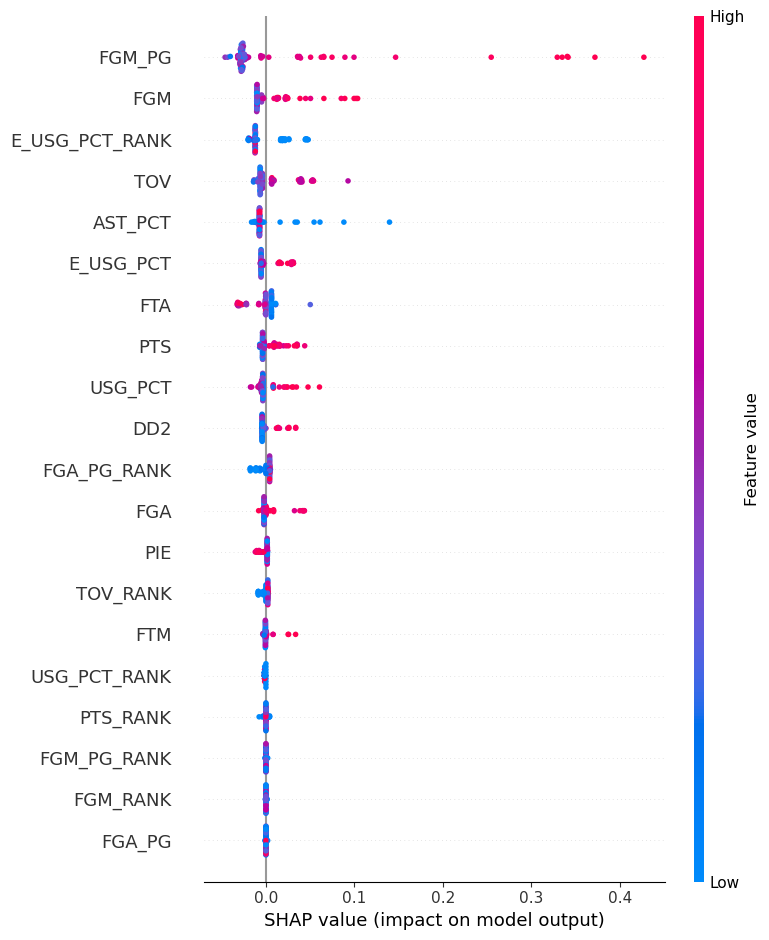

<Figure size 640x480 with 0 Axes>

In [85]:
# gradient boosting
explainer = shap.KernelExplainer(model_gb.predict, nba_2000_18_new)
shap_gb = explainer.shap_values(nba_2019_22_new)

In [104]:
df = pd.DataFrame(nba_2019_22_new, columns=['FGM', 'FGA', 'FTM', 'FTA', 'TOV', 'PTS', 'DD2', 'FGM_RANK', 'FGA_RANK',
       'TOV_RANK', 'PTS_RANK', 'AST_PCT', 'USG_PCT', 'E_USG_PCT', 'PIE',
       'USG_PCT_RANK', 'E_USG_PCT_RANK', 'PIE_RANK', 'FGM_PG_RANK',
       'FGA_PG_RANK'])
feature_names = list(df.columns)
plt.switch_backend('Agg')
shap.summary_plot(shap_gb, df, feature_names=feature_names)
# save the plot as an image
plt.savefig('gb_shap_summary_plot.png')

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


Using 566 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 78/78 [15:09<00:00, 11.66s/it]
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


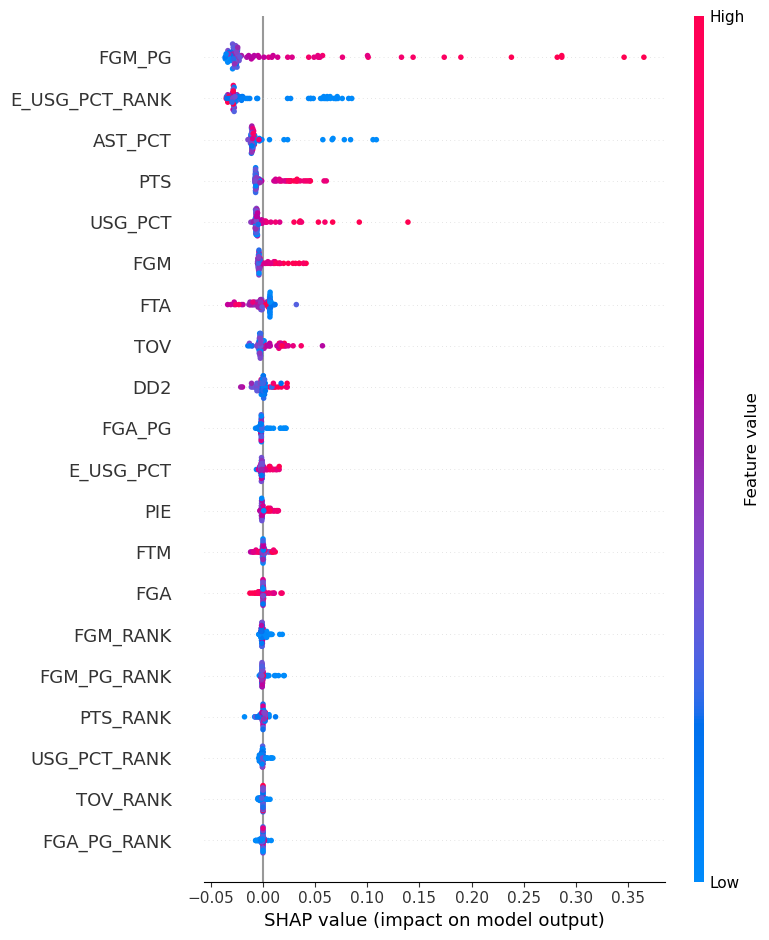

<Figure size 640x480 with 0 Axes>

In [86]:
# random forest
explainer = shap.KernelExplainer(model_rf.predict, nba_2000_18_new)
shap_rf = explainer.shap_values(nba_2019_22_new)

In [105]:
# save random forest SHAP value plot
df = pd.DataFrame(nba_2019_22_new, columns=['FGM', 'FGA', 'FTM', 'FTA', 'TOV', 'PTS', 'DD2', 'FGM_RANK', 'FGA_RANK',
       'TOV_RANK', 'PTS_RANK', 'AST_PCT', 'USG_PCT', 'E_USG_PCT', 'PIE',
       'USG_PCT_RANK', 'E_USG_PCT_RANK', 'PIE_RANK', 'FGM_PG_RANK',
       'FGA_PG_RANK'])
feature_names = list(df.columns)
plt.switch_backend('Agg')
shap.summary_plot(shap_rf, df, feature_names=feature_names)
# save the plot as an image
plt.savefig('rf_shap_summary_plot.png')

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


18/18 [==============================] - 0s 1ms/step


Using 566 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
  0%|          | 0/78 [00:00<?, ?it/s]

36932/36932 [==============================] - 13s 355us/step


  1%|▏         | 1/78 [00:26<33:32, 26.13s/it]

36932/36932 [==============================] - 13s 350us/step


  3%|▎         | 2/78 [00:47<29:33, 23.33s/it]

36932/36932 [==============================] - 13s 352us/step


  4%|▍         | 3/78 [01:08<28:00, 22.41s/it]

36932/36932 [==============================] - 13s 351us/step


  5%|▌         | 4/78 [01:30<27:06, 21.98s/it]

36932/36932 [==============================] - 13s 350us/step


  6%|▋         | 5/78 [01:51<26:37, 21.88s/it]

36932/36932 [==============================] - 13s 351us/step


  8%|▊         | 6/78 [02:13<26:01, 21.68s/it]

36932/36932 [==============================] - 14s 374us/step


  9%|▉         | 7/78 [02:35<25:58, 21.95s/it]

36932/36932 [==============================] - 15s 414us/step


 10%|█         | 8/78 [02:59<26:15, 22.50s/it]

36932/36932 [==============================] - 13s 351us/step


 12%|█▏        | 9/78 [03:20<25:26, 22.12s/it]

36932/36932 [==============================] - 13s 350us/step


 13%|█▎        | 10/78 [03:41<24:46, 21.86s/it]

36932/36932 [==============================] - 13s 351us/step


 14%|█▍        | 11/78 [04:03<24:21, 21.81s/it]

36932/36932 [==============================] - 13s 349us/step


 15%|█▌        | 12/78 [04:24<23:49, 21.66s/it]

36932/36932 [==============================] - 13s 349us/step


 17%|█▋        | 13/78 [04:46<23:21, 21.57s/it]

36932/36932 [==============================] - 13s 353us/step


 18%|█▊        | 14/78 [05:07<23:00, 21.57s/it]

36932/36932 [==============================] - 13s 359us/step


 19%|█▉        | 15/78 [05:29<22:48, 21.72s/it]

36932/36932 [==============================] - 14s 370us/step


 21%|██        | 16/78 [05:52<22:37, 21.90s/it]

36932/36932 [==============================] - 13s 362us/step


 22%|██▏       | 17/78 [06:14<22:17, 21.92s/it]

36932/36932 [==============================] - 14s 373us/step


 23%|██▎       | 18/78 [06:36<22:06, 22.11s/it]

36932/36932 [==============================] - 14s 365us/step


 24%|██▍       | 19/78 [06:58<21:45, 22.12s/it]

36932/36932 [==============================] - 13s 362us/step


 26%|██▌       | 20/78 [07:20<21:21, 22.09s/it]

36932/36932 [==============================] - 13s 359us/step


 27%|██▋       | 21/78 [07:42<20:58, 22.09s/it]

36932/36932 [==============================] - 13s 351us/step


 28%|██▊       | 22/78 [08:04<20:24, 21.86s/it]

36932/36932 [==============================] - 13s 353us/step


 29%|██▉       | 23/78 [08:25<19:53, 21.71s/it]

36932/36932 [==============================] - 13s 353us/step


 31%|███       | 24/78 [08:47<19:30, 21.68s/it]

36932/36932 [==============================] - 14s 375us/step


 32%|███▏      | 25/78 [09:09<19:21, 21.92s/it]

36932/36932 [==============================] - 14s 369us/step


 33%|███▎      | 26/78 [09:32<19:12, 22.16s/it]

36932/36932 [==============================] - 13s 356us/step


 35%|███▍      | 27/78 [09:54<18:44, 22.05s/it]

36932/36932 [==============================] - 15s 407us/step


 36%|███▌      | 28/78 [10:17<18:46, 22.54s/it]

36932/36932 [==============================] - 13s 351us/step


 37%|███▋      | 29/78 [10:39<18:07, 22.20s/it]

36932/36932 [==============================] - 13s 356us/step


 38%|███▊      | 30/78 [11:00<17:36, 22.01s/it]

36932/36932 [==============================] - 13s 351us/step


 40%|███▉      | 31/78 [11:22<17:11, 21.94s/it]

36932/36932 [==============================] - 13s 351us/step


 41%|████      | 32/78 [11:44<16:42, 21.79s/it]

36932/36932 [==============================] - 13s 353us/step


 42%|████▏     | 33/78 [12:05<16:16, 21.69s/it]

36932/36932 [==============================] - 13s 356us/step


 44%|████▎     | 34/78 [12:27<15:54, 21.69s/it]

36932/36932 [==============================] - 14s 377us/step


 45%|████▍     | 35/78 [12:50<15:46, 22.02s/it]

36932/36932 [==============================] - 13s 354us/step


 46%|████▌     | 36/78 [13:11<15:19, 21.89s/it]

36932/36932 [==============================] - 13s 357us/step


 47%|████▋     | 37/78 [13:33<14:56, 21.88s/it]

36932/36932 [==============================] - 14s 366us/step


 49%|████▊     | 38/78 [13:56<14:43, 22.10s/it]

36932/36932 [==============================] - 14s 379us/step


 50%|█████     | 39/78 [14:18<14:29, 22.29s/it]

36932/36932 [==============================] - 13s 353us/step


 51%|█████▏    | 40/78 [14:40<13:59, 22.08s/it]

36932/36932 [==============================] - 13s 359us/step


 53%|█████▎    | 41/78 [15:02<13:39, 22.16s/it]

36932/36932 [==============================] - 13s 355us/step


 54%|█████▍    | 42/78 [15:24<13:11, 21.99s/it]

36932/36932 [==============================] - 13s 350us/step


 55%|█████▌    | 43/78 [15:45<12:43, 21.82s/it]

36932/36932 [==============================] - 13s 353us/step


 56%|█████▋    | 44/78 [16:07<12:19, 21.76s/it]

36932/36932 [==============================] - 13s 364us/step


 58%|█████▊    | 45/78 [16:29<12:01, 21.85s/it]

36932/36932 [==============================] - 13s 353us/step


 59%|█████▉    | 46/78 [16:50<11:34, 21.72s/it]

36932/36932 [==============================] - 13s 353us/step


 60%|██████    | 47/78 [17:12<11:09, 21.61s/it]

36932/36932 [==============================] - 13s 354us/step


 62%|██████▏   | 48/78 [17:34<10:51, 21.71s/it]

36932/36932 [==============================] - 13s 364us/step


 63%|██████▎   | 49/78 [17:56<10:30, 21.76s/it]

36932/36932 [==============================] - 14s 367us/step


 64%|██████▍   | 50/78 [18:18<10:11, 21.85s/it]

36932/36932 [==============================] - 13s 353us/step


 65%|██████▌   | 51/78 [18:39<09:47, 21.77s/it]

36932/36932 [==============================] - 13s 361us/step


 67%|██████▋   | 52/78 [19:01<09:26, 21.78s/it]

36932/36932 [==============================] - 13s 359us/step


 68%|██████▊   | 53/78 [19:23<09:04, 21.78s/it]

36932/36932 [==============================] - 13s 350us/step


 69%|██████▉   | 54/78 [19:44<08:40, 21.68s/it]

36932/36932 [==============================] - 14s 366us/step


 71%|███████   | 55/78 [20:06<08:20, 21.77s/it]

36932/36932 [==============================] - 13s 353us/step


 72%|███████▏  | 56/78 [20:28<07:58, 21.73s/it]

36932/36932 [==============================] - 13s 362us/step


 73%|███████▎  | 57/78 [20:50<07:37, 21.80s/it]

36932/36932 [==============================] - 13s 361us/step


 74%|███████▍  | 58/78 [21:12<07:19, 21.98s/it]

36932/36932 [==============================] - 14s 376us/step


 76%|███████▌  | 59/78 [21:35<07:00, 22.14s/it]

36932/36932 [==============================] - 13s 358us/step


 77%|███████▋  | 60/78 [21:57<06:36, 22.02s/it]

36932/36932 [==============================] - 14s 371us/step


 78%|███████▊  | 61/78 [22:19<06:17, 22.19s/it]

36932/36932 [==============================] - 14s 366us/step


 79%|███████▉  | 62/78 [22:41<05:54, 22.15s/it]

36932/36932 [==============================] - 13s 354us/step


 81%|████████  | 63/78 [23:03<05:29, 21.95s/it]

36932/36932 [==============================] - 13s 351us/step


 82%|████████▏ | 64/78 [23:24<05:04, 21.77s/it]

36932/36932 [==============================] - 13s 363us/step


 83%|████████▎ | 65/78 [23:46<04:42, 21.77s/it]

36932/36932 [==============================] - 13s 353us/step


 85%|████████▍ | 66/78 [24:07<04:19, 21.64s/it]

36932/36932 [==============================] - 13s 359us/step


 86%|████████▌ | 67/78 [24:29<03:59, 21.79s/it]

36932/36932 [==============================] - 13s 356us/step


 87%|████████▋ | 68/78 [24:51<03:38, 21.85s/it]

36932/36932 [==============================] - 13s 354us/step


 88%|████████▊ | 69/78 [25:13<03:15, 21.75s/it]

36932/36932 [==============================] - 13s 353us/step


 90%|████████▉ | 70/78 [25:34<02:53, 21.69s/it]

36932/36932 [==============================] - 13s 357us/step


 91%|█████████ | 71/78 [25:56<02:31, 21.69s/it]

36932/36932 [==============================] - 14s 373us/step


 92%|█████████▏| 72/78 [26:18<02:11, 21.87s/it]

36932/36932 [==============================] - 13s 352us/step


 94%|█████████▎| 73/78 [26:40<01:48, 21.79s/it]

36932/36932 [==============================] - 13s 353us/step


 95%|█████████▍| 74/78 [27:01<01:26, 21.71s/it]

36932/36932 [==============================] - 13s 353us/step


 96%|█████████▌| 75/78 [27:23<01:05, 21.79s/it]

36932/36932 [==============================] - 14s 368us/step


 97%|█████████▋| 76/78 [27:46<00:43, 21.94s/it]

36932/36932 [==============================] - 13s 362us/step


 99%|█████████▊| 77/78 [28:08<00:21, 21.95s/it]

36932/36932 [==============================] - 13s 361us/step


100%|██████████| 78/78 [28:30<00:00, 21.93s/it]


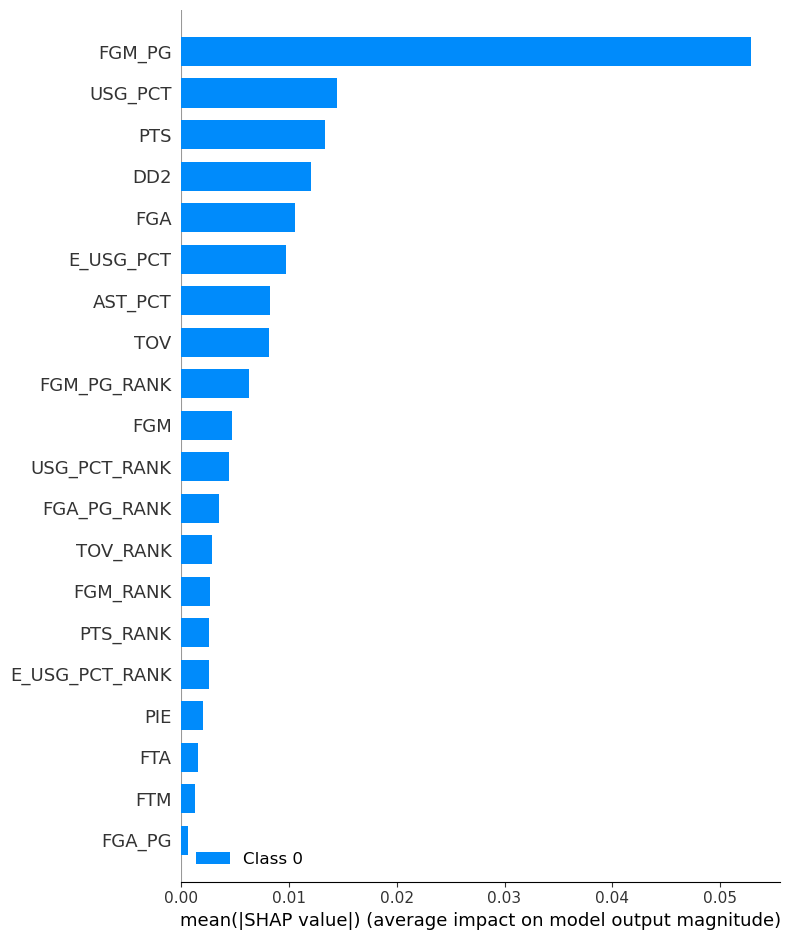

<Figure size 640x480 with 0 Axes>

In [87]:
# neural network SHAP value
explainer = shap.KernelExplainer(model_nn.predict, nba_2000_18_new)
shap_nn = explainer.shap_values(nba_2019_22_new)

In [106]:
df = pd.DataFrame(nba_2019_22_new, columns=['FGM', 'FGA', 'FTM', 'FTA', 'TOV', 'PTS', 'DD2', 'FGM_RANK', 'FGA_RANK',
       'TOV_RANK', 'PTS_RANK', 'AST_PCT', 'USG_PCT', 'E_USG_PCT', 'PIE',
       'USG_PCT_RANK', 'E_USG_PCT_RANK', 'PIE_RANK', 'FGM_PG_RANK',
       'FGA_PG_RANK'])
feature_names = list(df.columns)
plt.switch_backend('Agg')
shap.summary_plot(shap_nn, df, feature_names=feature_names)
# save the plot as an image
plt.savefig('nn_shap_summary_plot.png')

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
